In [1]:
import numpy as np
import os
import pandas as pd
from utils import sample_k_movies
from MAB_class import MABAgent, LinUCB_MABAgent
import random
import matplotlib.pyplot as plt

In [2]:
# Loading the data

movies_data_path = os.path.join(os.path.pardir, 'data/processed_data.csv') 
movies_data = pd.read_csv(movies_data_path)

In [3]:
# Load ratings data
path_ratings = os.path.join(os.path.pardir, 'data/ratings.csv')
ratings_df = pd.read_csv(path_ratings)

# Preparing the datasets for the agents
ratings = ratings_df['rating'].to_numpy()
movieId_of_rating = ratings_df['movieId'].to_numpy()
movie_ids = set(ratings_df['movieId'].unique().tolist())

<strong> Constructing a dictionnary that matches movies ID to their title </strong>

In [4]:
# Dictionnary that macthes moviesID to their original title
movieId_title = dict()

titles = movies_data['original_title'].tolist()
movieId = movies_data['movieId'].tolist()

for title, id in zip(titles, movieId):
    movieId_title[id] = title

In [5]:
# Extracting only the movies we will be using and keeping just the relevant columnns

movies_data = movies_data[movies_data['movieId'].isin(movie_ids)]
movies_indices = movies_data['movieId'].to_numpy()
movies_data = movies_data[['movieId', 'original_title']]

In [6]:
movies_data.head()

,movieId,original_title
0,318,The Million Dollar Hotel
1,296,Terminator 3: Rise of the Machines
2,593,Солярис
3,260,The 39 Steps
4,480,Monsoon Wedding


## <strong><font color='red'> <div align='center'> I will first experiment with 100 movies </font></div></strong>

In [7]:
from MAB_class import UCB_MABAgent, TS_MABAgent, EXP3_MABAgent

# Define number of movies
n_movies = len(movies_indices)
n_rounds = 10000
n_actions = 100
indices = random.sample([i for i in range(n_movies)], n_actions)

# Define the datasets that will be used to train the agents
movies_id_k = movies_indices[indices]
mask = [i for i in range(movieId_of_rating.size) if movieId_of_rating[i] in movies_id_k]
movieId_of_rating_k = movieId_of_rating[mask]
ratings_k = ratings[mask]

max_reward = 5
true_rewards = ratings_k

rewardsXmovie_indices = movieId_of_rating_k 
actionXmovie_indices = movies_id_k

sigma = 1
eta = 0.5

UCB_agent = UCB_MABAgent(n_rounds, n_actions, max_reward, true_rewards, rewardsXmovie_indices, actionXmovie_indices)
TS_agent = TS_MABAgent(n_rounds, n_actions, sigma, max_reward, true_rewards, rewardsXmovie_indices, actionXmovie_indices)
EXP_agent = EXP3_MABAgent(eta, n_rounds, n_actions, max_reward, true_rewards, rewardsXmovie_indices, actionXmovie_indices)

<strong> Let run the UCB Agent on our selected movies dataset </strong>

In [8]:
cumulative_regret_ucb = UCB_agent.run()

<strong> Let now run the Thompson Sampling Agent on our selected movies dataset </strong>

In [9]:
cumulative_regret_ts = TS_agent.run()

<strong> Let now run the EXP3 Agent on our selected movies dataset </strong>

In [10]:
cumulative_regret_exp = EXP_agent.run()

<strong> Plotting the cumulative regret for both agents </strong>

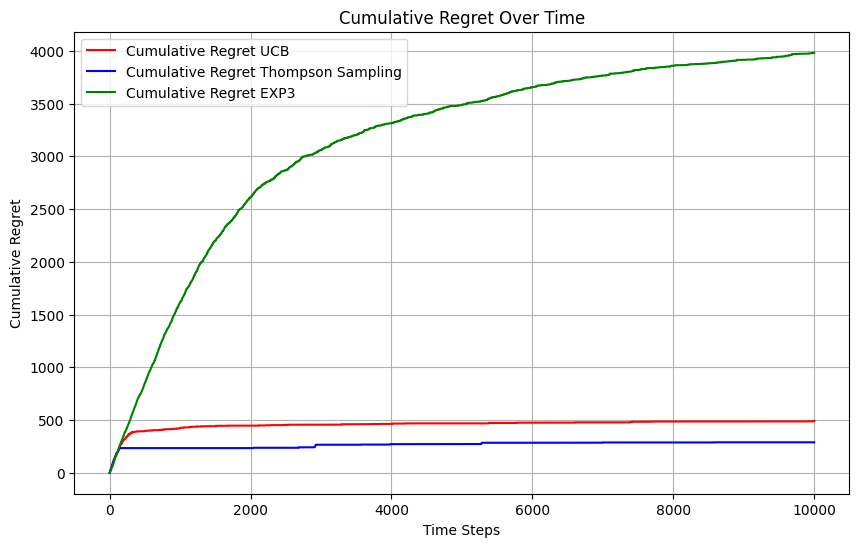

In [11]:
time_steps_ts = range(len(cumulative_regret_ts))  # Assuming each entry corresponds to a time step
time_steps_ucb = range(len(cumulative_regret_ucb))  # Assuming each entry corresponds to a time step
time_steps_exp = range(len(cumulative_regret_exp))  # Assuming each entry corresponds to a time step

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_ts, cumulative_regret_ts, linestyle='-', color='r', label='Cumulative Regret UCB')
plt.plot(time_steps_ucb, cumulative_regret_ucb, linestyle='-', color='b', label='Cumulative Regret Thompson Sampling')
plt.plot(time_steps_exp, cumulative_regret_exp, linestyle='-', color='g', label='Cumulative Regret EXP3')

# Customizing the plot
plt.title('Cumulative Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<strong> Let run the UCB, EXP3 and Thomspon Sampling Agent on our selected movies dataset </strong>

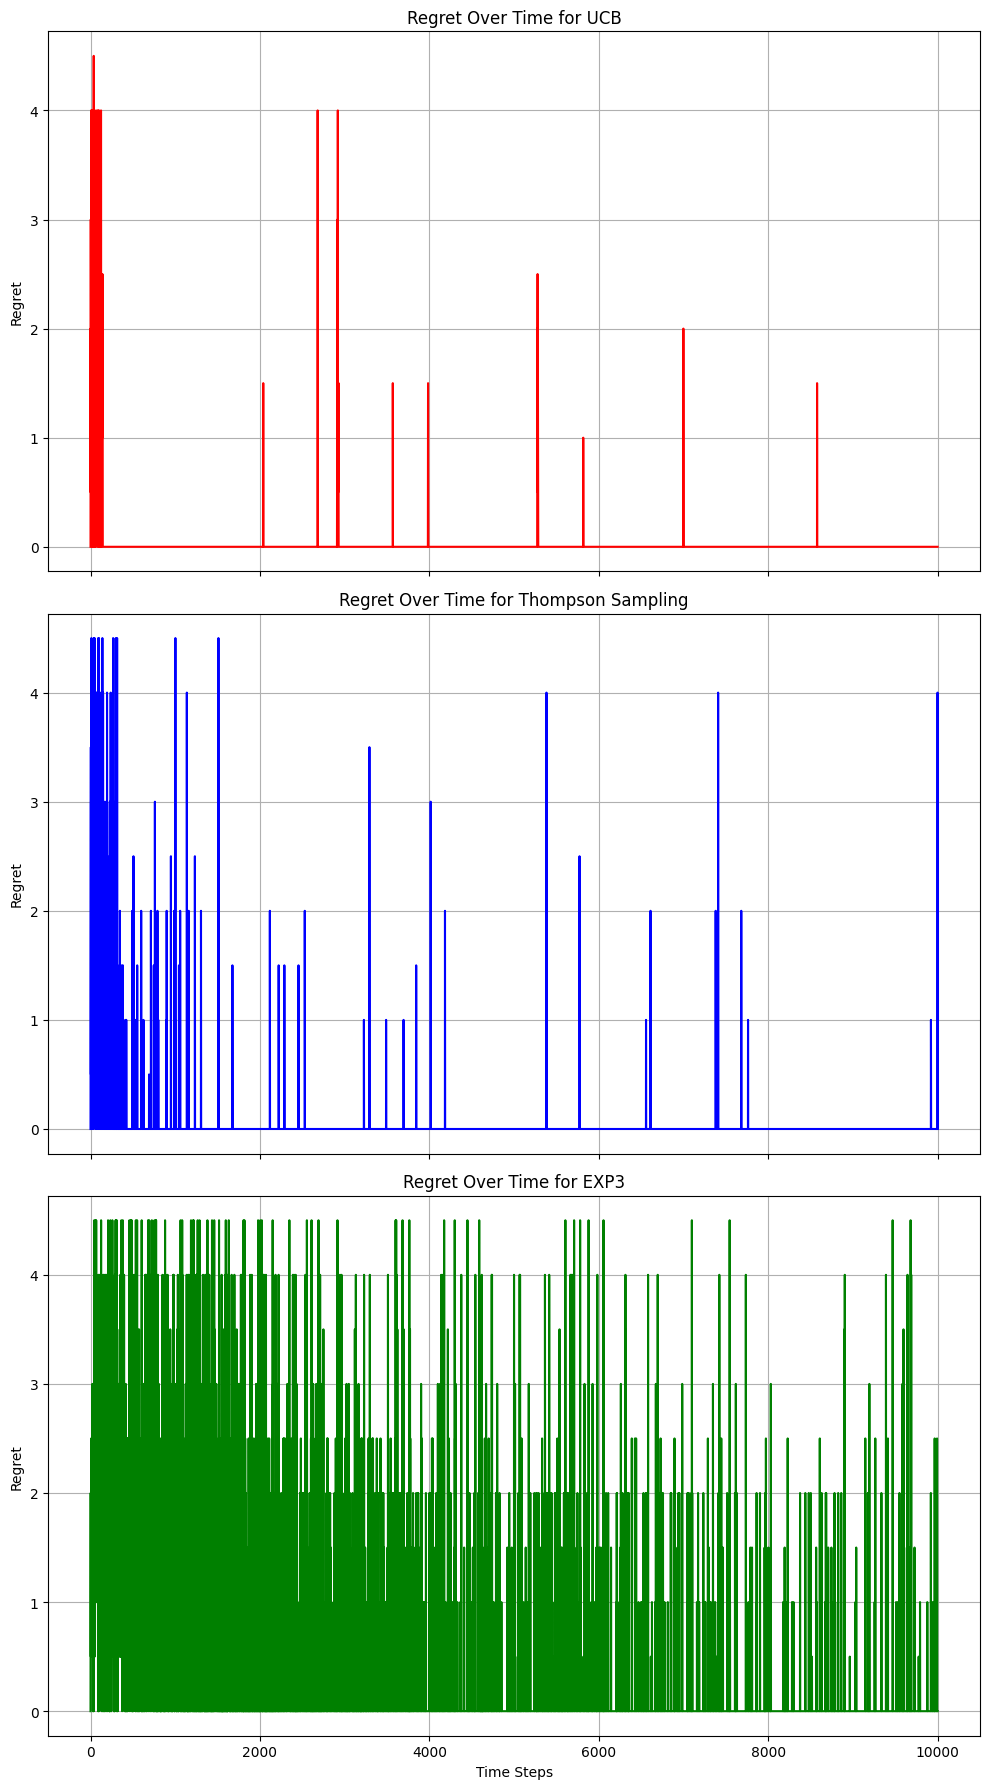

In [12]:
ucb_cumulative_regret = UCB_agent.cumulative_regret
ts_cumulative_regret = TS_agent.cumulative_regret
exp_cumulative_regret = EXP_agent.cumulative_regret

# Calculate regrets for each algorithm at each time step
ucb_regret = [0]
ts_regret = [0]
exp_regret = [0]

for i in range(1, n_rounds):
    ucb_regret.append(ucb_cumulative_regret[i] - ucb_cumulative_regret[i-1])
    ts_regret.append(ts_cumulative_regret[i] - ts_cumulative_regret[i-1])
    exp_regret.append(exp_cumulative_regret[i] - exp_cumulative_regret[i-1])

# Time steps
time_steps = range(n_rounds)  

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# Plot for UCB
axs[0].plot(time_steps[:10000], ucb_regret[:10000], linestyle='-', color='r')
axs[0].set_title('Regret Over Time for UCB')
axs[0].set_ylabel('Regret')
axs[0].grid(True)

# Plot for Thompson Sampling
axs[1].plot(time_steps[:10000], ts_regret[:10000], linestyle='-', color='b')
axs[1].set_title('Regret Over Time for Thompson Sampling')
axs[1].set_ylabel('Regret')
axs[1].grid(True)

# Plot for EXP3
axs[2].plot(time_steps[:10000], exp_regret[:10000], linestyle='-', color='g')
axs[2].set_title('Regret Over Time for EXP3')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Regret')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()


<strong> Let see movies ratings at this stage for each agent </strong>

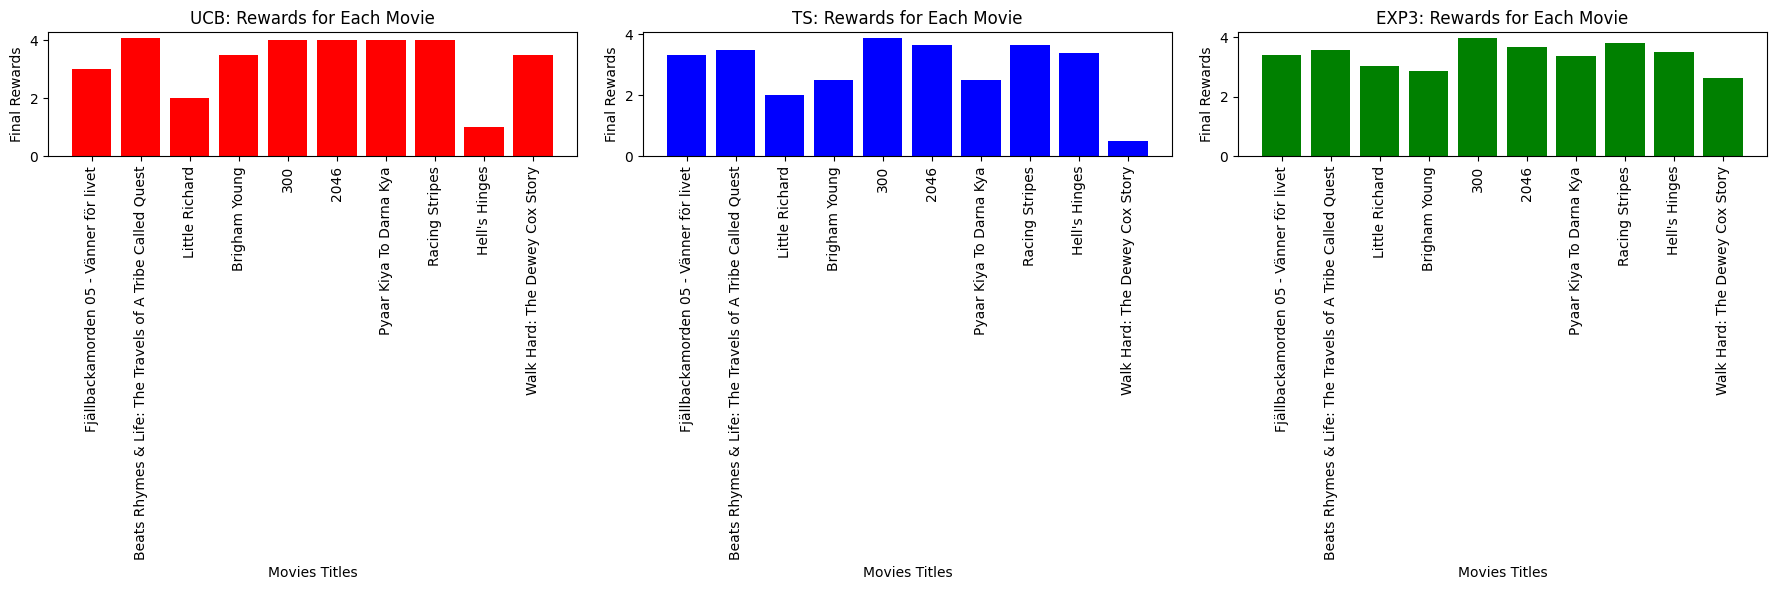

In [13]:
ucb_ratings = UCB_agent.total_reward / UCB_agent.action_counts
ts_ratings = TS_agent.total_reward / TS_agent.action_counts
exp_ratings = EXP_agent.total_reward / EXP_agent.action_counts  

movies_titles = [movieId_title[id] for id in movies_id_k]

# To make it visually better

n_samples = 10

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted to 3 columns

# Plot for UCB
axes[0].bar(movies_titles[:n_samples], ucb_ratings[:n_samples], color='red')
axes[0].set_xlabel('Movies Titles')
axes[0].set_ylabel('Final Rewards')
axes[0].set_title('UCB: Rewards for Each Movie')
axes[0].tick_params(axis='x', rotation=90)

# Plot for Thompson Sampling (TS)
axes[1].bar(movies_titles[:n_samples], ts_ratings[:n_samples], color='blue')
axes[1].set_xlabel('Movies Titles')
axes[1].set_ylabel('Final Rewards')
axes[1].set_title('TS: Rewards for Each Movie')
axes[1].tick_params(axis='x', rotation=90)

# Plot for EXP3
axes[2].bar(movies_titles[:n_samples], exp_ratings[:n_samples], color='green')
axes[2].set_xlabel('Movies Titles')
axes[2].set_ylabel('Final Rewards')
axes[2].set_title('EXP3: Rewards for Each Movie')
axes[2].tick_params(axis='x', rotation=90)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show plot
plt.show()

## <strong><font color='red'> <div align='center'> I will now experiment with 1000 movies </font></div></strong>

In [14]:
from MAB_class import UCB_MABAgent, TS_MABAgent, EXP3_MABAgent

# Define number of movies
n_movies = len(movies_indices)
n_rounds = 10000
n_actions = 1000
indices = random.sample([i for i in range(n_movies)], n_actions)

# Define the datasets that will be used to train the agents
movies_id_k = movies_indices[indices]
mask = [i for i in range(movieId_of_rating.size) if movieId_of_rating[i] in movies_id_k]
movieId_of_rating_k = movieId_of_rating[mask]
ratings_k = ratings[mask]

max_reward = 5
true_rewards = ratings_k

rewardsXmovie_indices = movieId_of_rating_k 
actionXmovie_indices = movies_id_k

sigma = 1
eta = 2

UCB_agent = UCB_MABAgent(n_rounds, n_actions, max_reward, true_rewards, rewardsXmovie_indices, actionXmovie_indices)
TS_agent = TS_MABAgent(n_rounds, n_actions, sigma, max_reward, true_rewards, rewardsXmovie_indices, actionXmovie_indices)
EXP_agent = EXP3_MABAgent(eta, n_rounds, n_actions, max_reward, true_rewards, rewardsXmovie_indices, actionXmovie_indices)

<strong> Let run the UCB, EXP3 and Thomspon Sampling Agent on our selected movies dataset </strong>

In [15]:
cumulative_regret_ucb = UCB_agent.run()
cumulative_regret_exp = EXP_agent.run()
cumulative_regret_ts = TS_agent.run()

<strong> Plotting the cumulative regret for both agents </strong>

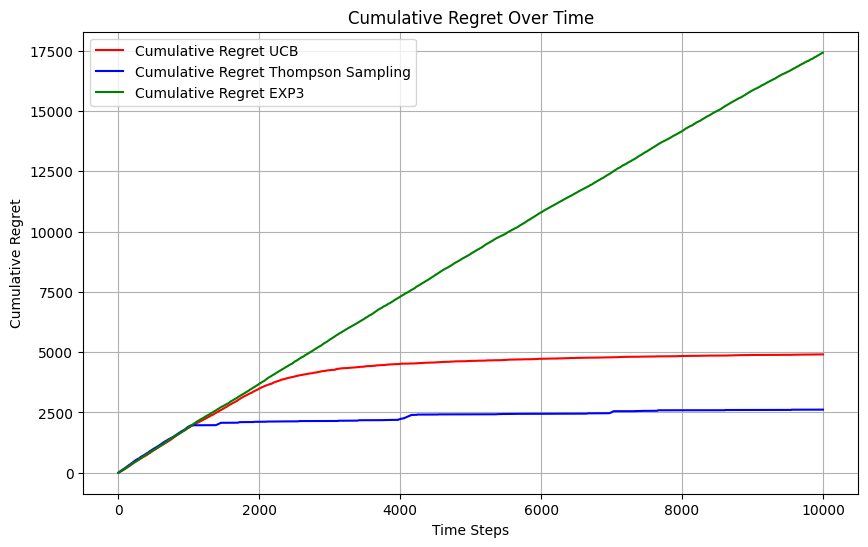

In [16]:
time_steps_ts = range(len(cumulative_regret_ts))  
time_steps_ucb = range(len(cumulative_regret_ucb))  
time_steps_exp = range(len(cumulative_regret_exp))  

# Plotting  
plt.figure(figsize=(10, 6))
plt.plot(time_steps_ts, cumulative_regret_ts, linestyle='-', color='r', label='Cumulative Regret UCB')
plt.plot(time_steps_ucb, cumulative_regret_ucb, linestyle='-', color='b', label='Cumulative Regret Thompson Sampling')
plt.plot(time_steps_exp, cumulative_regret_exp, linestyle='-', color='g', label='Cumulative Regret EXP3')

# Customizing the plot
plt.title('Cumulative Regret Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<strong> Let now plot the regret for all agents </strong>

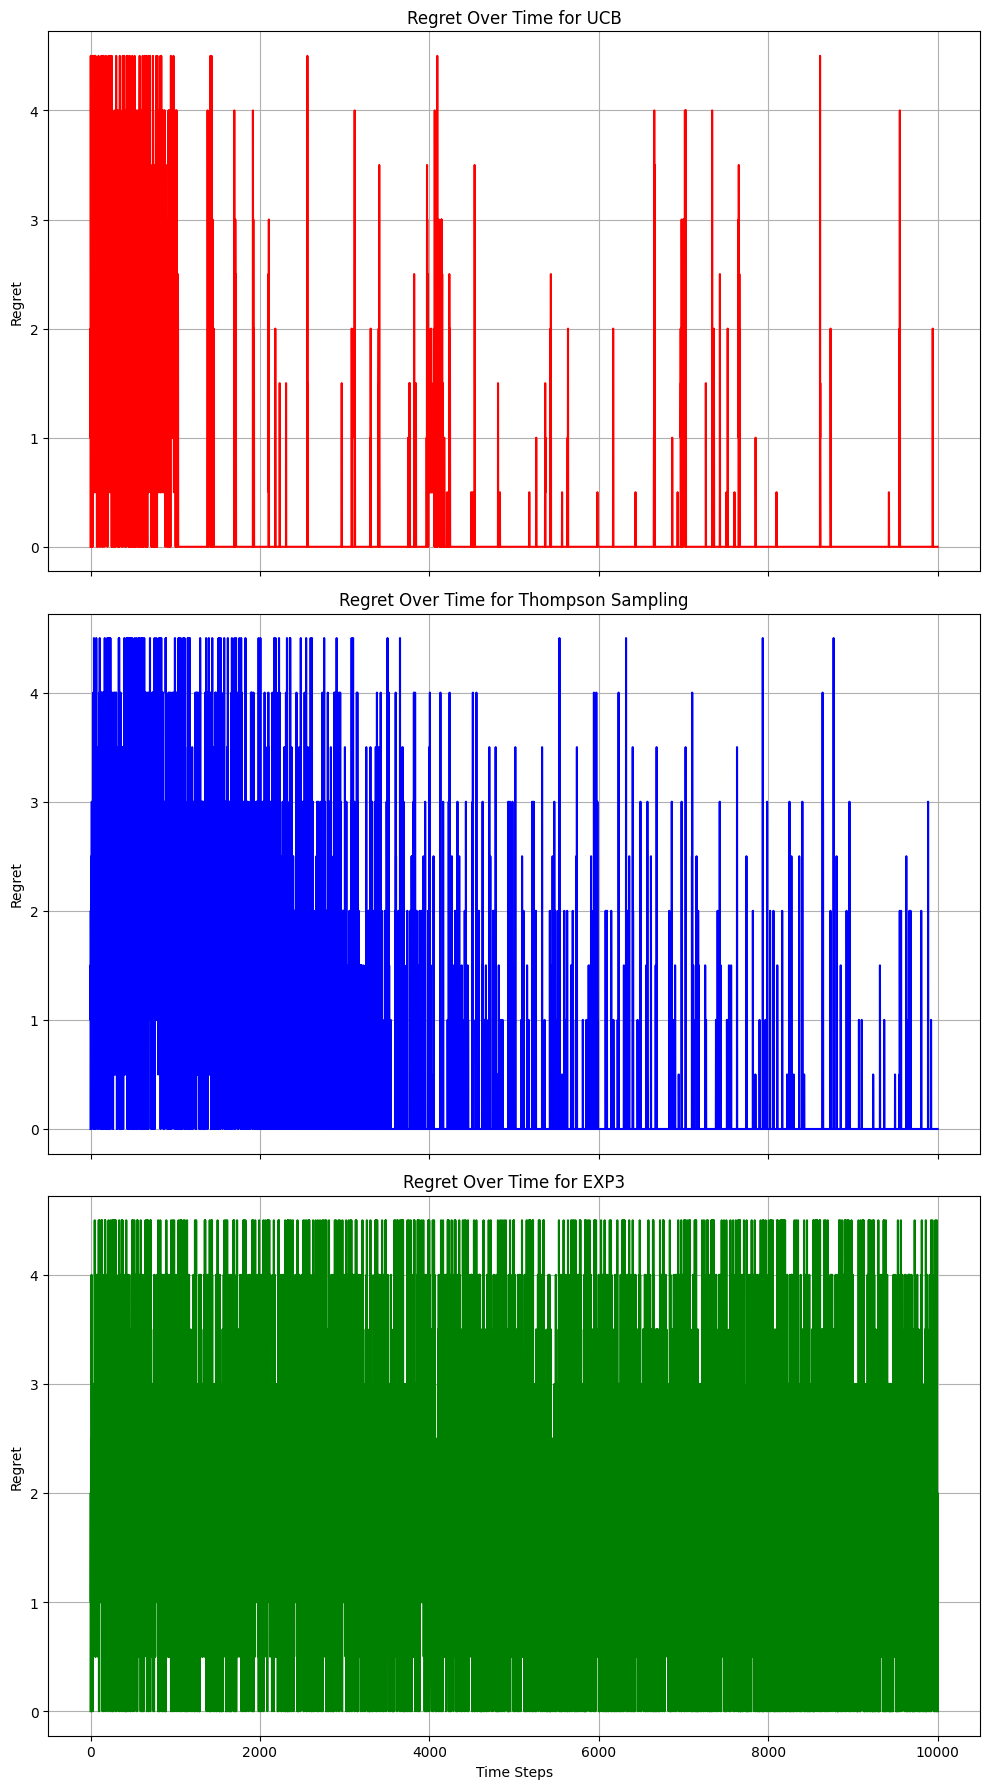

In [17]:
ucb_cumulative_regret = UCB_agent.cumulative_regret
ts_cumulative_regret = TS_agent.cumulative_regret
exp_cumulative_regret = EXP_agent.cumulative_regret

# Calculate regrets for each algorithm at each time step
ucb_regret = [0]
ts_regret = [0]
exp_regret = [0]

for i in range(1, n_rounds):
    ucb_regret.append(ucb_cumulative_regret[i] - ucb_cumulative_regret[i-1])
    ts_regret.append(ts_cumulative_regret[i] - ts_cumulative_regret[i-1])
    exp_regret.append(exp_cumulative_regret[i] - exp_cumulative_regret[i-1])

# Time steps
time_steps = range(n_rounds)  

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# Plot for UCB
axs[0].plot(time_steps[:10000], ucb_regret[:10000], linestyle='-', color='r')
axs[0].set_title('Regret Over Time for UCB')
axs[0].set_ylabel('Regret')
axs[0].grid(True)

# Plot for Thompson Sampling
axs[1].plot(time_steps[:10000], ts_regret[:10000], linestyle='-', color='b')
axs[1].set_title('Regret Over Time for Thompson Sampling')
axs[1].set_ylabel('Regret')
axs[1].grid(True)

# Plot for EXP3
axs[2].plot(time_steps[:10000], exp_regret[:10000], linestyle='-', color='g')
axs[2].set_title('Regret Over Time for EXP3')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Regret')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

<strong> Let see movies ratings at this stage for each agent </strong>

C:\Users\Mrabe\AppData\Local\Temp\ipykernel_30876\1661817477.py:35: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from current font.
  plt.tight_layout()
C:\Users\Mrabe\AppData\Local\Temp\ipykernel_30876\1661817477.py:35: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
C:\Users\Mrabe\AppData\Local\Temp\ipykernel_30876\1661817477.py:35: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  plt.tight_layout()
C:\Users\Mrabe\AppData\Local\Temp\ipykernel_30876\1661817477.py:35: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from current font.
  plt.tight_layout()
C:\Users\Mrabe\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Mrabe\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarni

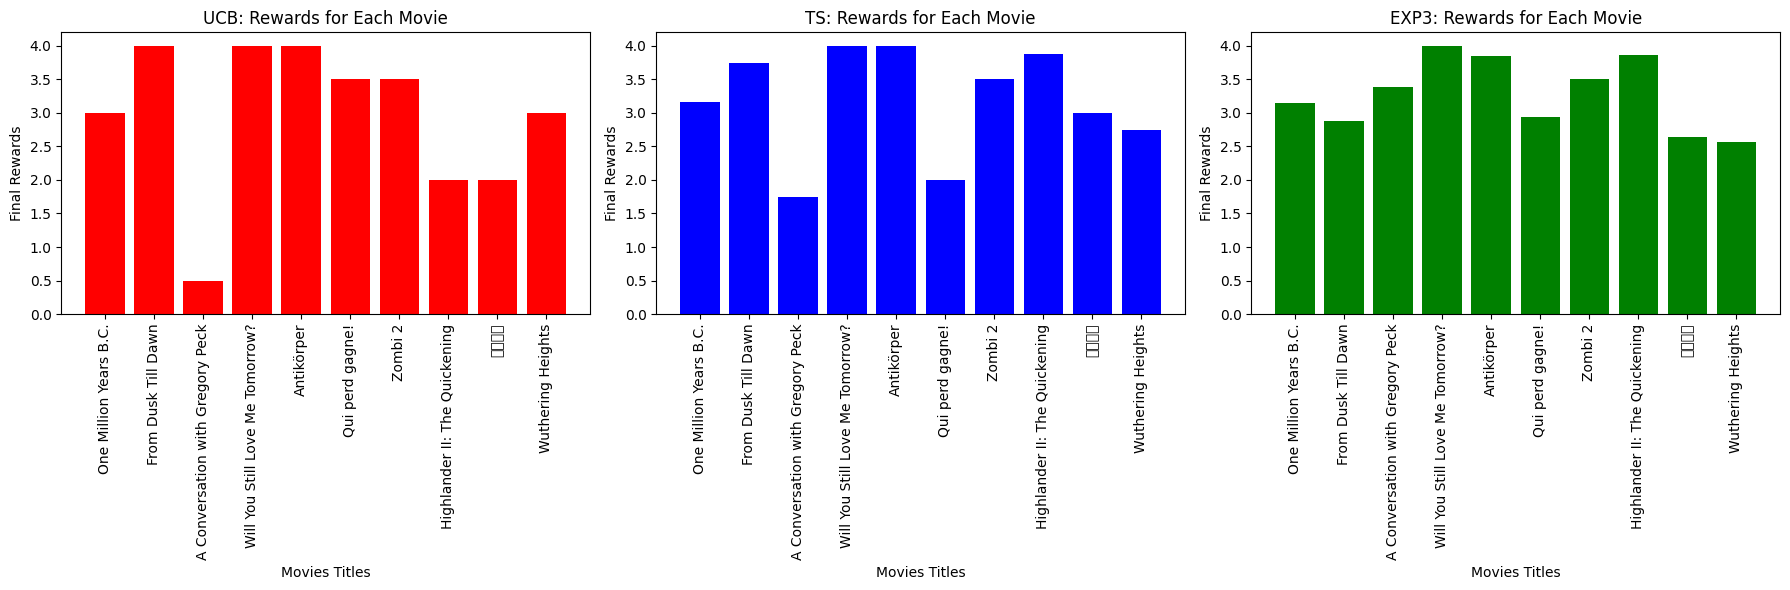

In [18]:
ucb_ratings = UCB_agent.total_reward / UCB_agent.action_counts
ts_ratings = TS_agent.total_reward / TS_agent.action_counts
exp_ratings = EXP_agent.total_reward / EXP_agent.action_counts  

movies_titles = [movieId_title[id] for id in movies_id_k]

# To make it visually better

n_samples = 10

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted to 3 columns

# Plot for UCB
axes[0].bar(movies_titles[:n_samples], ucb_ratings[:n_samples], color='red')
axes[0].set_xlabel('Movies Titles')
axes[0].set_ylabel('Final Rewards')
axes[0].set_title('UCB: Rewards for Each Movie')
axes[0].tick_params(axis='x', rotation=90)

# Plot for Thompson Sampling (TS)
axes[1].bar(movies_titles[:n_samples], ts_ratings[:n_samples], color='blue')
axes[1].set_xlabel('Movies Titles')
axes[1].set_ylabel('Final Rewards')
axes[1].set_title('TS: Rewards for Each Movie')
axes[1].tick_params(axis='x', rotation=90)

# Plot for EXP3
axes[2].bar(movies_titles[:n_samples], exp_ratings[:n_samples], color='green')
axes[2].set_xlabel('Movies Titles')
axes[2].set_ylabel('Final Rewards')
axes[2].set_title('EXP3: Rewards for Each Movie')
axes[2].tick_params(axis='x', rotation=90)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show plot
plt.show()

### <strong>Conclusion</strong>

The cumulative regret graphs for both 100 and 1000 movies demonstrate the distinct behavior of the three bandit algorithms—UCB, Thompson Sampling, and EXP3—over time.

1. **UCB (Upper Confidence Bound)**: In both experiments, UCB shows a steady and controlled increase in cumulative regret. Over 100 movies, UCB performs well, with a much lower cumulative regret compared to EXP3. In the 1000-movie experiment, UCB's cumulative regret remains linear and consistently below that of Thompson Sampling for most time steps, highlighting its stability in balancing exploration and exploitation.

2. **Thompson Sampling**: In both scenarios, Thompson Sampling exhibits the best performance overall. It achieves the lowest cumulative regret, particularly noticeable after 1000 movies. Its cumulative regret grows slowly over time, indicating efficient learning of optimal actions. This result is expected, as Thompson Sampling is known for its effective exploration-exploitation trade-off in stochastic settings, especially when the reward distribution is well-defined.

3. **EXP3 (Exponential-weight algorithm for Exploration and Exploitation)**: As anticipated, EXP3 shows the highest cumulative regret in both experiments, growing rapidly and continuously over time. This behavior is due to its design for adversarial settings, where it does not assume a stochastic reward distribution. Its cumulative regret is significantly higher after 1000 movies, suggesting that EXP3 may not be well-suited for the stochastic environment of movie recommendations, where the other algorithms perform better.

In summary, **Thompson Sampling** is the most effective in minimizing regret for movie recommendation tasks, followed by **UCB**, with **EXP3** being the least suitable for this type of problem. These results align with the theoretical expectations, where Thompson Sampling excels in stochastic environments, and EXP3 is better suited for adversarial ones.
